In [42]:
# Import required packages
import numpy as np
import pandas as pd
import cv2
import sys
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [30]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


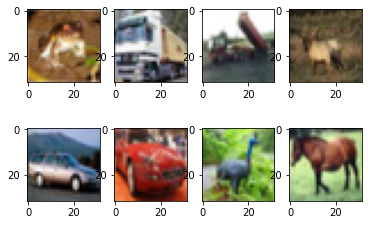

In [108]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [32]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [33]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [34]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

Clean labels:
 frog truck truck  deer   car   car  bird horse
Predicted baseline labels:
 frog  ship truck  frog  ship   cat  deer horse


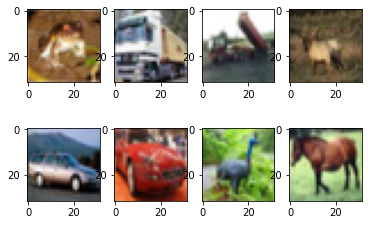

In [35]:
fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
print('Predicted baseline labels:')
print(' '.join('%5s' % classes[int(baseline_model(imgs[j])[0])] for j in range(8)))

### 2.2. Model I

In [45]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

x_train, x_test, y_train, y_test = train_test_split(imgs, noisy_labels, test_size = 0.2, random_state=42)
x_train = tf.cast(x_train, dtype='float32')/255.0
x_test = tf.cast(x_test, dtype='float32')/255.0
y_train = tf.one_hot(y_train, depth=10)
#y_test = tf.one_hot(y_test, depth=10)
start = time.time()

modelI = tf.keras.Sequential([
         tf.keras.layers.Conv2D(32,(3,3),padding='same', activation ='relu', input_shape=(32,32,3)),
         tf.keras.layers.MaxPooling2D((2,2)),
         tf.keras.layers.Conv2D(128,(3,3),padding='same', activation ='relu'),
         tf.keras.layers.MaxPooling2D((2,2)),
         tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
         tf.keras.layers.MaxPooling2D((2,2)),
         tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
         tf.keras.layers.MaxPooling2D((2,2)),
         tf.keras.layers.Flatten(),
         tf.keras.layers.Dense(128, activation = 'relu'),
         tf.keras.layers.Dense(64, activation = 'relu'),
         tf.keras.layers.Dropout(0.5),
         tf.keras.layers.Dense(10, activation = 'softmax')])
        
modelI.compile(optimizer= tf.keras.optimizers.Adam(0.001), loss = tf.keras.losses.CategoricalCrossentropy(),
               metrics = ['accuracy'])

modelI.fit(x_train, y_train, batch_size=64, epochs=10, validation_split= 0.2)
print('Model Training Time:', round((time.time() - start)/60, 2), 'mins')

Epoch 1/10
500/500 [==============================] - 51s 102ms/step - loss: 2.3038 - accuracy: 0.0986 - val_loss: 2.2957 - val_accuracy: 0.1091
Epoch 2/10
500/500 [==============================] - 51s 103ms/step - loss: 2.2872 - accuracy: 0.1301 - val_loss: 2.2787 - val_accuracy: 0.1400
Epoch 3/10
500/500 [==============================] - 52s 104ms/step - loss: 2.2711 - accuracy: 0.1463 - val_loss: 2.2576 - val_accuracy: 0.1723
Epoch 4/10
500/500 [==============================] - 51s 102ms/step - loss: 2.2566 - accuracy: 0.1697 - val_loss: 2.2579 - val_accuracy: 0.1770
Epoch 5/10
500/500 [==============================] - 54s 109ms/step - loss: 2.2503 - accuracy: 0.1703 - val_loss: 2.2445 - val_accuracy: 0.1944
Epoch 6/10
500/500 [==============================] - 51s 101ms/step - loss: 2.2397 - accuracy: 0.1827 - val_loss: 2.2416 - val_accuracy: 0.1990
Epoch 7/10
500/500 [==============================] - 51s 101ms/step - loss: 2.2275 - accuracy: 0.1986 - val_loss: 2.2271 - val_ac

In [48]:
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    image = tf.reshape(image, ((1,) + image.shape))
    predictions = modelI.predict(image)
    return np.argmax(predictions)

In [71]:
# Accuracy on subset of test set
preds = []
acc = []
for i, v in enumerate(x_test[:1000]):
    pred = model_I(v)
    preds.append(pred)
    if pred == y_test[i]:
        acc.append(1)
    else:
        acc.append(0)
print('Test accuracy:',sum(acc)/len(acc))

Test accuracy: 0.204


### 2.3. Model II (sl4983)

In [114]:
# Label cleaning model
imgs_modelII = imgs[0:10000]
noisy_labels_modelII = noisy_labels[0:10000]

X_train, X_test, y_train, y_test = train_test_split(imgs_modelII, clean_labels, test_size=0.2, random_state=63)
X_train = tf.cast(X_train,dtype='float32')/255.0
X_test = tf.cast(X_test,dtype='float32')/255.0
y_train = tf.one_hot(y_train, depth =10)
#y_test = tf.one_hot(y_test,depth = 10)
start = time.time()

model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32,(3,3),padding='same', activation ='relu', input_shape=(32,32,3), strides=(1,1)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(128,(3,3),padding='same', activation ='relu', strides=(1,1)),
        tf.keras.layers.Conv2D(64,(3,3),padding='same', activation ='relu', strides=(1,1)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        #tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation = 'softmax')])

model.compile(optimizer= tf.keras.optimizers.Adam(0.001), loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size=64, epochs=25, validation_split= 0.2)
print('Label Cleaning Model Training Time:', round((time.time() - start)/60, 2), 'mins')

Epoch 1/25
100/100 [==============================] - 14s 133ms/step - loss: 2.2639 - accuracy: 0.1213 - val_loss: 1.9211 - val_accuracy: 0.3363
Epoch 2/25
100/100 [==============================] - 13s 131ms/step - loss: 1.9528 - accuracy: 0.2843 - val_loss: 1.6469 - val_accuracy: 0.3744
Epoch 3/25
100/100 [==============================] - 13s 135ms/step - loss: 1.7174 - accuracy: 0.3648 - val_loss: 1.5560 - val_accuracy: 0.4094
Epoch 4/25
100/100 [==============================] - 14s 136ms/step - loss: 1.6086 - accuracy: 0.4073 - val_loss: 1.4235 - val_accuracy: 0.4762
Epoch 5/25
100/100 [==============================] - 14s 136ms/step - loss: 1.5424 - accuracy: 0.4467 - val_loss: 1.4037 - val_accuracy: 0.4900
Epoch 6/25
100/100 [==============================] - 14s 136ms/step - loss: 1.4161 - accuracy: 0.4869 - val_loss: 1.3699 - val_accuracy: 0.5044
Epoch 7/25
100/100 [==============================] - 13s 134ms/step - loss: 1.3371 - accuracy: 0.5202 - val_loss: 1.3162 - val_ac

In [115]:
def label_model(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    image = tf.reshape(image, ((1,) + image.shape))
    predictions = model.predict(image)
    return np.argmax(predictions)

In [116]:
preds = []
acc = []
for i, v in enumerate(X_test):
    pred = label_model(v)
    preds.append(pred)
    if pred == y_test[i]:
        acc.append(1)
    else:
        acc.append(0)
print('Test accuracy:',sum(acc)/len(acc))

Test accuracy: 0.5845


In [117]:
### Predict labels from label cleaning model
noisy_images = imgs[10000:]
noisy_images = tf.cast(noisy_images, dtype='float32')/255.0
predicted_labels = np.argmax(model.predict(noisy_images), axis=1)
new_labels = np.append(clean_labels, predicted_labels)

In [122]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[40000]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[40001]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[40002]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[40003]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[40004]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[40005]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[40006]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[40007]/255)

print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in np.arange(40000, 40008, 1)))
print('Predicted clean labels:')
print(' '.join('%5s' % classes[new_labels[j]] for j in np.arange(30000, 30008, 1)))

In [93]:
### Train Model-I with predicted_labels
### MODEL II
x_train, x_test, y_train, y_test = train_test_split(imgs, new_labels, test_size = 0.2, random_state=42)
x_train = tf.cast(x_train, dtype='float32')/255.0
x_test = tf.cast(x_test, dtype='float32')/255.0
y_train = tf.one_hot(y_train, depth=10)
#y_test = tf.one_hot(y_test, depth=10)
start = time.time()

modelII = tf.keras.Sequential([
         tf.keras.layers.Conv2D(32,(3,3),padding='same', activation ='relu', input_shape=(32,32,3)),
         tf.keras.layers.MaxPooling2D((2,2)),
         # tf.keras.layers.Dropout(0.25),
         tf.keras.layers.Conv2D(128,(3,3),padding='same', activation ='relu'),
         tf.keras.layers.MaxPooling2D((2,2)),
         # tf.keras.layers.Dropout(0.25),
         tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
         tf.keras.layers.MaxPooling2D((2,2)),
         tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
         tf.keras.layers.MaxPooling2D((2,2)),
         tf.keras.layers.Flatten(),
         tf.keras.layers.Dense(128, activation = 'relu'),
         tf.keras.layers.Dense(64, activation = 'relu'),
         tf.keras.layers.Dropout(0.5),
         tf.keras.layers.Dense(10, activation = 'softmax')])
        
modelII.compile(optimizer= tf.keras.optimizers.Adam(0.001), loss = tf.keras.losses.CategoricalCrossentropy(),
               metrics = ['accuracy'])

modelII.fit(x_train, y_train, batch_size=64, epochs=20, validation_split= 0.2)
print('Model Training Time:', round((time.time() - start)/60, 2), 'mins')

Epoch 1/20
500/500 [==============================] - 52s 103ms/step - loss: 2.0092 - accuracy: 0.2445 - val_loss: 1.3665 - val_accuracy: 0.4894
Epoch 2/20
500/500 [==============================] - 54s 107ms/step - loss: 1.4324 - accuracy: 0.4784 - val_loss: 1.1704 - val_accuracy: 0.5684
Epoch 3/20
500/500 [==============================] - 53s 106ms/step - loss: 1.2202 - accuracy: 0.5672 - val_loss: 1.1164 - val_accuracy: 0.5956
Epoch 4/20
500/500 [==============================] - 52s 105ms/step - loss: 1.1269 - accuracy: 0.6087 - val_loss: 1.0621 - val_accuracy: 0.6165
Epoch 5/20
500/500 [==============================] - 51s 102ms/step - loss: 1.0314 - accuracy: 0.6413 - val_loss: 1.0524 - val_accuracy: 0.6258
Epoch 6/20
500/500 [==============================] - 51s 102ms/step - loss: 0.9500 - accuracy: 0.6694 - val_loss: 1.0294 - val_accuracy: 0.6316
Epoch 7/20
500/500 [==============================] - 51s 103ms/step - loss: 0.8946 - accuracy: 0.6938 - val_loss: 1.0177 - val_ac

In [94]:
y_pred = np.argmax(modelII.predict(x_test), axis=1)
acc = (y_pred==y_test)
print('Model II Test Accuracy:', sum(acc)/len(acc))

Model II Test Accuracy: 0.6338


### 2.3. Model II (KG's model)

In [103]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...
import os
from inception import maybe_download, Inception, transfer_values_cache

def model_II(image, extracted_features=True):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...
    if extracted_features == False:
        model = Inception()
        output_path = "inception/"
        inception_train_output_path = os.path.join(output_path, 'inception_cifar10_train.pkl')
        inception_train_output = transfer_values_cache(cache_path=inception_train_output_path,
                                                       images=image,
                                                       model=model)
    
    inception_train_output = pd.read_pickle('inception/inception_cifar10_train.pkl')
    
    label_cleaning_input = np.concatenate((inception_train_output[:10000], noisy_labels[:10000].reshape(10000, 1)), axis=1)
    
    label_cleaning_model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    label_cleaning_model.compile(optimizer='SGD',
                                 loss='sparse_categorical_crossentropy',
                                 metrics=['sparse_categorical_accuracy'])

    label_cleaning_model.fit(label_cleaning_input, clean_labels, batch_size=32, epochs=10, verbose=1)

    label_cleaning_test = np.concatenate((inception_train_output[10000:], noisy_labels[10000:].reshape(40000, 1)), axis=1)
    predicted_clean_labels = label_cleaning_model.predict(label_cleaning_test)
    predicted_clean_labels = predicted_clean_labels.argmax(axis=-1)
    
    return predicted_clean_labels
    

In [8]:
import os
from inception import maybe_download, Inception, transfer_values_cache

model = Inception()
output_path = "inception/"
inception_train_output_path = os.path.join(output_path, 'inception_cifar10_train.pkl')
inception_train_output = transfer_values_cache(cache_path=inception_train_output_path,
                                               images=imgs,
                                               model=model)

- Processing image:      1 / 50000

2022-10-26 03:20:38.253637: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


- Processing image:  50000 / 50000
- Data saved to cache-file: inception/inception_cifar10_train.pkl


Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 23s 2ms/sample - loss: 0.9739 - sparse_categorical_accuracy: 0.7395
Epoch 2/10
10000/10000 [==============================] - 0s 27us/sample - loss: 0.4759 - sparse_categorical_accuracy: 0.8557
Epoch 3/10
10000/10000 [==============================] - 0s 25us/sample - loss: 0.4018 - sparse_categorical_accuracy: 0.8738
Epoch 4/10
10000/10000 [==============================] - 0s 25us/sample - loss: 0.3665 - sparse_categorical_accuracy: 0.8805
Epoch 5/10
10000/10000 [==============================] - 0s 24us/sample - loss: 0.3426 - sparse_categorical_accuracy: 0.8850
Epoch 6/10
10000/10000 [==============================] - 0s 24us/sample - loss: 0.3220 - sparse_categorical_accuracy: 0.8930
Epoch 7/10
10000/10000 [==============================] - 0s 27us/sample - loss: 0.3066 - sparse_categorical_accuracy: 0.8967
Epoch 8/10
10000/10000 [==============================] - 0s 29us/sample - loss: 0.2940 - spars

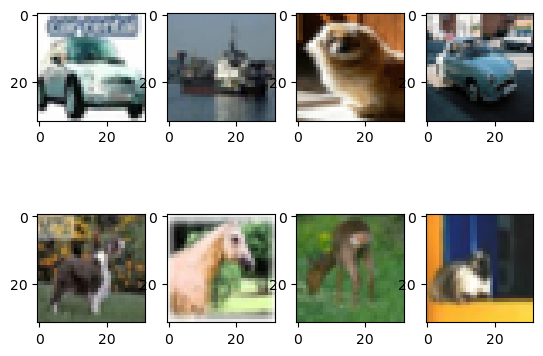

In [104]:
predicted_clean_labels = model_II(imgs)

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[40000]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[40001]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[40002]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[40003]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[40004]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[40005]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[40006]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[40007]/255)

print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in np.arange(40000, 40008, 1)))
print('Predicted clean labels:')
print(' '.join('%5s' % classes[predicted_clean_labels[j]] for j in np.arange(30000, 30008, 1)))

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [ ]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.